In [4]:
!pip install tensorflow


In [5]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Input, Flatten
from tensorflow.keras.layers import MaxPooling2D

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
path = "C:\\Users\\manan\\Faceid"
os.chdir(path)
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH  = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH , NEW_PATH)

In [ ]:
import uuid

In [ ]:
os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[90:90+250,100:100+250,:]
    #collect anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    cv2.imshow('Image Collection', frame)
 
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Get Image Directories


In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\8a02ab7d-61e5-11ed-8116-975062e6057d.jpg'


In [13]:
def preprocess(file_path):
    #read in image from file_path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    #preprcessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [14]:
img = preprocess('data\\anchor\\8b71c3dd-61e5-11ed-ae14-975062e6057d.jpg')

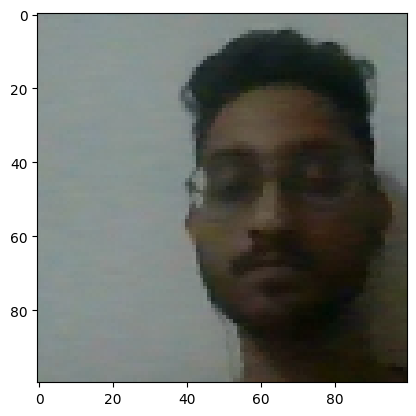

In [15]:
plt.imshow(img)

In [16]:
# Create Labelled Datasets

In [17]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example = samples.next()

In [20]:
example

(b'data\\anchor\\79c750d5-61e5-11ed-a0bb-975062e6057d.jpg',
 b'data\\positive\\9b8e0d90-61e5-11ed-8a63-975062e6057d.jpg',
 1.0)

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*example)

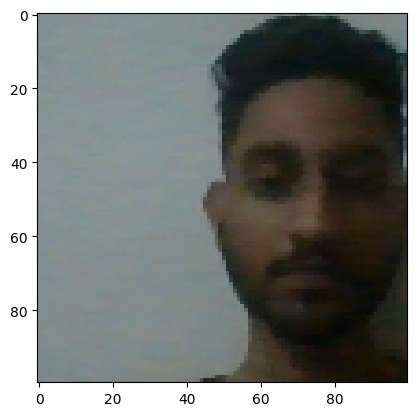

In [23]:
plt.imshow(res[1])

In [24]:
res[2]

1.0

In [25]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [26]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
from tensorflow.keras.layers import Dense

In [29]:
#function for embedding layer
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')
    #first block
    c1 = Conv2D(64,(10,10), activation ='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #second block
    c2 = Conv2D(128,(7,7), activation ='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #third block
    c3 = Conv2D(128,(4,4), activation ='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #final embedding block
    c4 = Conv2D(256,(4,4), activation ='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp] , outputs=[d1], name='embedding')

In [30]:
embedding = make_embedding()

In [31]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [32]:
#Siamese L1 Distance Class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    #Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [33]:
l1 = L1Dist()

In [34]:
l1

In [35]:
 validation_image = Input(name='validation_img', shape=(100,100,3))
input_image = Input(name='input_img', shape=(100,100,3))

In [36]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [37]:
siamese_layer = L1Dist()

In [38]:
distances = siamese_layer(inp_embedding, val_embedding)

In [39]:
classifier = Dense(1, activation='sigmoid')(distances)

In [40]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [41]:
siamese_network =  Model(inputs= [input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [42]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [43]:
def make_siamese_model():
    
    #Anchor image inputs in te network
    input_image = Input(name = 'input_img', shape=(100,100,3))
    
    #validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #calssification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs= [input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [44]:
siamese_model = make_siamese_model()

In [45]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Setup Loss and Optimizer

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [47]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Estrablish CheckPoints

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

#Build Train Step Function

In [49]:
test_batch = train_data.as_numpy_iterator()

In [50]:
batch_1 = test_batch.next()

In [51]:
batch_1[0]

array([[[[0.53333336, 0.5686275 , 0.5568628 ],
         [0.5254902 , 0.5686275 , 0.5529412 ],
         [0.5203431 , 0.56642157, 0.5507353 ],
         ...,
         [0.5137255 , 0.5529412 , 0.50980395],
         [0.51960784, 0.5529412 , 0.50980395],
         [0.5178922 , 0.5492647 , 0.5061275 ]],

        [[0.5360294 , 0.5732843 , 0.5605392 ],
         [0.5355392 , 0.57965684, 0.56397057],
         [0.53357846, 0.5806373 , 0.564951  ],
         ...,
         [0.5019608 , 0.5480392 , 0.5107843 ],
         [0.5012255 , 0.54362744, 0.50710785],
         [0.49803922, 0.5392157 , 0.5029412 ]],

        [[0.5262255 , 0.56936276, 0.5536765 ],
         [0.527451  , 0.5737745 , 0.55808824],
         [0.52892154, 0.58259803, 0.5647059 ],
         ...,
         [0.5088235 , 0.55196077, 0.525     ],
         [0.5058824 , 0.5497549 , 0.51691175],
         [0.50686276, 0.5509804 , 0.5176471 ]],

        ...,

        [[0.49607843, 0.55490196, 0.54313725],
         [0.50686276, 0.5509804 , 0.5362745 ]

In [52]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        
        #Get anchor and positive/negative Images
        x = batch[:2]
        #Get Lable
        y = batch[2]
        
        # Forward Pass
        yhat = siamese_model(x, training=True)
        # calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    #calculate gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate updated weights and apply the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss
    

#Build Training Loop

In [53]:
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [54]:
# train the model

In [55]:
EPOCHS = 50

In [69]:
os.listdir(checkpoint_dir)

['checkpoint',
 'ckpt-1.data-00000-of-00001',
 'ckpt-1.index',
 'ckpt-2.data-00000-of-00001',
 'ckpt-2.index',
 'ckpt-3.data-00000-of-00001',
 'ckpt-3.index',
 'ckpt-4.data-00000-of-00001',
 'ckpt-4.index',
 'ckpt-5.data-00000-of-00001',
 'ckpt-5.index']

In [121]:
to_restore = tf.Variable(tf.zeros([5]))
print(to_restore.numpy())  # All zeros
fake_layer = tf.train.Checkpoint(bias=to_restore)
fake_net = tf.train.Checkpoint(l1=fake_layer)
new_root = tf.train.Checkpoint(net=fake_net)
status = new_root.restore(tf.train.latest_checkpoint('checkpoint_prefix'))
print(to_restore.numpy())  # This gets the restored value.

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


In [122]:
#latest = model.load_weights(checkpoint_dir)

In [147]:
#train(train_data, EPOCHS)

# Evaluate Model

In [124]:
from tensorflow.keras.metrics import Precision, Recall

In [125]:
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [126]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[0.49267444],
       [0.01928136],
       [0.0263868 ],
       [0.01879462],
       [0.48854694],
       [0.4984047 ],
       [0.01876106],
       [0.46370664],
       [0.38542777],
       [0.02750281],
       [0.41409007],
       [0.04822182],
       [0.03424822],
       [0.019065  ],
       [0.4330728 ],
       [0.49147356]], dtype=float32)

In [127]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [128]:
y_true

array([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [129]:
# Creeating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)
m.result().numpy()


0.0

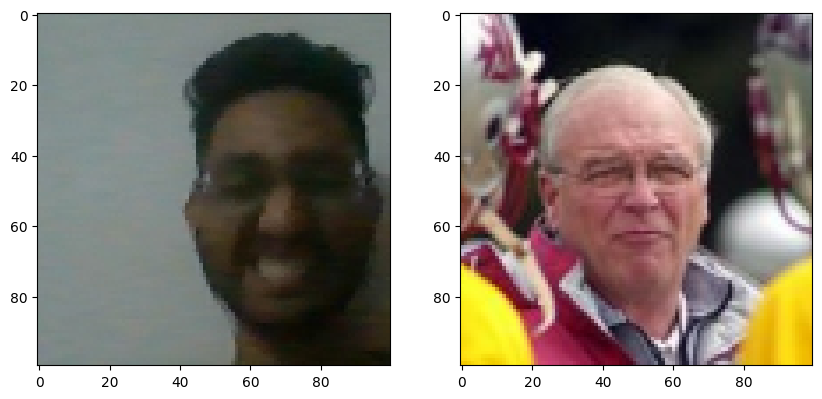

In [130]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

In [131]:
## Save a Model
siamese_model.save('siamesemodel.h5')

In [132]:
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects = {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [133]:
model.predict([test_input, test_val])

1/1 [==============================] - 4s 4s/step


array([[0.49267444],
       [0.01928136],
       [0.0263868 ],
       [0.01879462],
       [0.48854694],
       [0.4984047 ],
       [0.01876106],
       [0.46370664],
       [0.38542777],
       [0.02750281],
       [0.41409007],
       [0.04822182],
       [0.03424822],
       [0.019065  ],
       [0.4330728 ],
       [0.49147356]], dtype=float32)

In [134]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Real time test


In [135]:
 os.listdir(os.path.join('application_data', 'verification_images'))

['92e585b2-61e5-11ed-b111-975062e6057d.jpg',
 '9b24875f-61e5-11ed-9ce7-975062e6057d.jpg',
 '9b3ff1ce-61e5-11ed-93d9-975062e6057d.jpg',
 '9b575f67-61e5-11ed-9094-975062e6057d.jpg',
 '9b5fbb53-61e5-11ed-b396-975062e6057d.jpg',
 '9b6dc4c7-61e5-11ed-8270-975062e6057d.jpg',
 '9b7c43f5-61e5-11ed-8e08-975062e6057d.jpg',
 '9b8e0d90-61e5-11ed-8a63-975062e6057d.jpg',
 '9b9c5f77-61e5-11ed-abcd-975062e6057d.jpg',
 '9bb3315c-61e5-11ed-be0a-975062e6057d.jpg',
 '9c185bf6-61e5-11ed-98da-975062e6057d.jpg',
 '9c26ba6f-61e5-11ed-82d2-975062e6057d.jpg',
 '9c2f31f4-61e5-11ed-85a3-975062e6057d.jpg',
 '9c3d79e1-61e5-11ed-af63-975062e6057d.jpg',
 '9c4bc389-61e5-11ed-b6bc-975062e6057d.jpg',
 '9c546398-61e5-11ed-8c11-975062e6057d.jpg',
 '9c619803-61e5-11ed-a7dd-975062e6057d.jpg',
 '9c702325-61e5-11ed-ada3-975062e6057d.jpg',
 '9c7e5b9b-61e5-11ed-af2d-975062e6057d.jpg',
 '9c86b125-61e5-11ed-879d-975062e6057d.jpg',
 '9cb0a778-61e5-11ed-a8c3-975062e6057d.jpg',
 '9cd144f3-61e5-11ed-8f0c-975062e6057d.jpg',
 '9cd9d402

In [144]:
# verification function
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Prediction
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    # Detection Threshold
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification Threshold
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified
        

## OpenCV real Time Verification

In [145]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[90:90+250,100:100+250,:]
    cv2.imshow('Image Collection', frame)
    #collect anchor
    if cv2.waitKey(1) & 0XFF == ord('v'):
        imgname = os.path.join('application_data','input_image','input_image.jpg')
        cv2.imwrite(imgname, frame)
    
        #Run Verification
        results, verified = verify(model,0.5,0.5)
        print(verified)

 
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 277ms/step
False
1/1 [==============================] - 0s 238ms/step
False
